# Twitterでフォロワーをクラスタリングしてみた。
---
データ収集

### 使うライブラリ
networkx, pandas, matplotlib

## 目次
- クラスタリングに必要なデータとは、
- クラスタリングをするために必要な手順（ライブラリや、データ整形など）
- 結果見る
- 結果をDB情報から引っ張ってきてさらにみて見る。
- 結果を元に、クラスタの属性分析をする方向性を固める。
    - 今のところ、自己紹介文を使って、tf-idfで処理し、属性を表す単語をピックアップする予定。
- 属性分析

## クラスタリングに必要なデータとは。
簡単にまとめると、  
ノードとエッジのみ。

今回の場合は、  
ノード = フォロワー（twitterユーザー）  
エッジ = 繋がりの関係（誰が誰をフォローしているのかということ）

ちょっとしたデモやる

In [1]:
import os, sys
sys.path.append('..')

import json
import time
import random
from tqdm import tqdm

from functions import twitter

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

### DBからpandas.DataFrameに代入 

In [2]:
import pandas as pd
import psycopg2

# 接続情報
connection_config = {
    'host': os.environ['RDS_HOST'],
    'port': '5432',
    'database': os.environ['RDS_DATABASE'],
    'user': os.environ['RDS_USERNAME'],
    'password': os.environ['RDS_PASSWORD']
}

# 接続
connection = psycopg2.connect(**connection_config)
df = pd.read_sql(sql="SELECT * FROM for_research.user_info;", con=connection)
df.head()

,slave_screen_name,user_id,screen_name,friends_count,followers_count,self_discription,protected
0,rui_308,1027812767661678592,chelios406,35,19,シェブ チェリオスです。充電しないと即停止します。面白いツイートはできません。基本、夜しか出...,0
1,rui_308,473583122,hasamarhythm,1080,794,みんなもレッツ諦念,0
2,rui_308,742897072228044800,ke_mirakao8,102,22,大学生。クリープハイプ/andymori/ナードマグネット/teto/リーガルリリー/Hel...,0
3,rui_308,3184817456,JSUBC,1194,1201,J-subculture,0
4,rui_308,3220618783,Luisthebestcat,81,44,I love it all japanese music like indigo la En...,0


In [3]:
df.shape

(5361, 7)

In [4]:
df = df[df.protected==0]

In [5]:
df.shape

(4969, 7)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116b57518>,
      dtype=object)

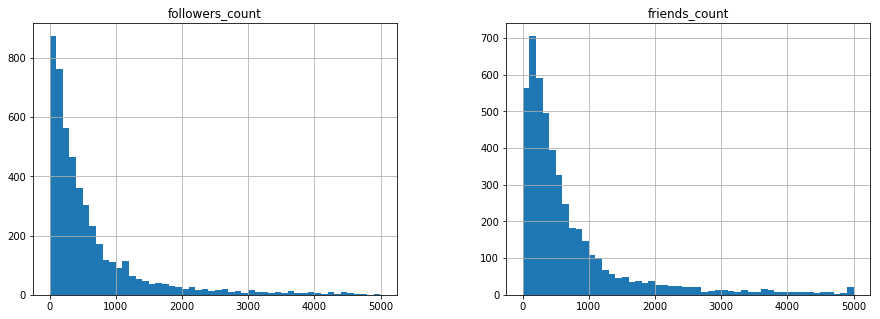

In [6]:
max_count = 5000

df.loc[(df.friends_count<max_count) & (df.followers_count<max_count), ['friends_count', 'followers_count']].hist(bins=50, figsize=(15,5))

In [16]:
test_df = df[(400<df.friends_count) & (df.friends_count<=500)]
test_df = test_df.reset_index(drop=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ac58780>,
      dtype=object)

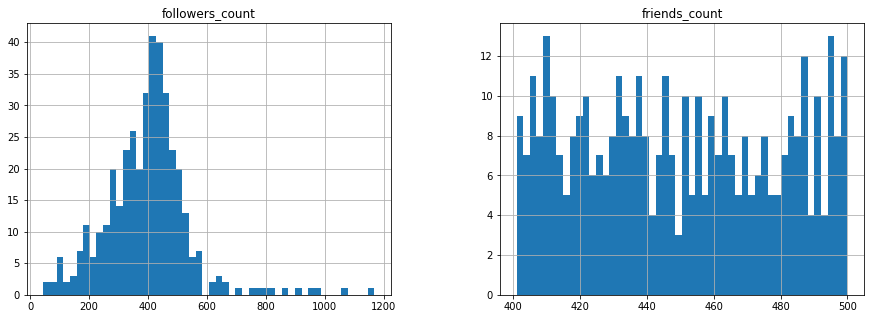

In [12]:
test_df.loc[:, ['friends_count', 'followers_count']].hist(bins=50, figsize=(15,5))

### 指定範囲ユーザーのフォロワーidsを取得

In [19]:
from db import psql_save
psql = psql_save()

tw = twitter()

value_list = []
test_df = test_df.reset_index(drop=True)

for i in tqdm(range(len(test_df))):
    user_id = test_df['user_id'][i]
    screen_name = test_df['screen_name'][i]
    
    friends_ids = tw.getFriendIds(screen_name)
    str_friends_ids = ','.join(map(str, friends_ids))
    
    psql.insert_friends(int(user_id), screen_name, str_friends_ids, value_list=None)
    time.sleep(60*random.uniform(0.5,1.5))